<a href="https://colab.research.google.com/github/folga67/data_mining/blob/master/OFedorova_hw_les4x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_lesson4/data.csv')
df.head(3)

recency  history  used_discount  ...  channel            offer  conversion
0       10   142.44              1  ...    Phone  Buy One Get One           0
1        6   329.08              1  ...      Web         No Offer           0
2        7   180.65              0  ...      Web  Buy One Get One           0

[3 rows x 9 columns]

In [ ]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df.head(3)

recency  history  used_discount  ...  channel        treatment  target
0       10   142.44              1  ...    Phone  Buy One Get One       0
1        6   329.08              1  ...      Web         No Offer       0
2        7   180.65              0  ...      Web  Buy One Get One       0

[3 rows x 9 columns]

In [ ]:
df['treatment'].unique().tolist()

['Buy One Get One', 'No Offer', 'Discount']

In [ ]:
df = df.replace({'Buy One Get One': 1, 'Discount': 1, 'No Offer':0})
df.head(3), df.shape

(   recency  history  used_discount  ...  channel treatment  target
 0       10   142.44              1  ...    Phone         1       0
 1        6   329.08              1  ...      Web         0       0
 2        7   180.65              0  ...      Web         1       0
 
 [3 rows x 9 columns], (64000, 9))

In [ ]:
df.groupby(['target']).describe()

recency                                ... treatment                    
          count      mean       std  min  25%  ...       min  25%  50%  75%  max
target                                         ...                              
0       54606.0  5.872505  3.500573  1.0  3.0  ...       0.0  0.0  1.0  1.0  1.0
1        9394.0  5.131467  3.481646  1.0  2.0  ...       0.0  1.0  1.0  1.0  1.0

[2 rows x 48 columns]

сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [ ]:
## разделим на тренировочную и тестовую выборки
index_train, index_test = train_test_split(df.index, test_size=0.3, random_state=0)
index_train.shape, index_test.shape

((44800,), (19200,))

In [ ]:
X_train = df.loc[index_train, :].drop(['treatment', 'target'], axis = 1)

In [ ]:
y_train = df.loc[index_train, 'target']
y_train

26161    0
10495    0
50047    0
56688    1
62760    0
        ..
45891    0
52416    1
42613    1
43567    0
2732     0
Name: target, Length: 44800, dtype: int64

In [ ]:
treat_train = df.loc[index_train, 'treatment']
X_train.shape, y_train.shape, treat_train.shape

((44800, 7), (44800,), (44800,))

In [ ]:

X_test = df.loc[index_test, :].drop(['treatment', 'target'], 1)
y_test =  df.loc[index_test, 'target']
treat_test = df.loc[index_test, 'treatment']
print(X_test.shape, y_test.shape, treat_test.shape)

(19200, 7) (19200,) (19200,)


In [ ]:
y_train.value_counts(normalize=True)

0    0.852121
1    0.147879
Name: target, dtype: float64

Исследуем данные

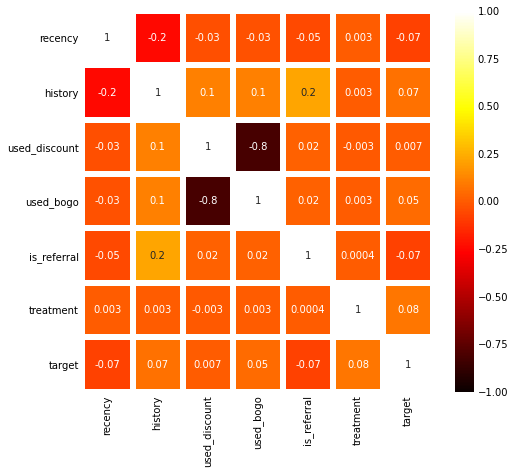

In [ ]:
plt.figure(figsize = (7, 7))
sns.heatmap(df.corr(), annot = True, fmt = '0.1g', vmin =-1, vmax = 1, center = 0, cmap = 'hot', linewidths=5)
plt.tick_params(axis='both', which='major', labelsize=10)

Видим, что самое большая линейная зависимость в признаков used_discount и used_bogo. Что такое последнее, не понятно. Но будем иметь ввиду, что группа пользователей, которые имеют оба "положительных значений" этих признаков "оригинальна".


In [ ]:
## таких оказалось больше 10%. Посмотрим их распределение по target и увидим, что соотношение сильно отличается от общего по датасету
X_train.loc[df['used_bogo'] + df['used_discount'] ==2].shape
a = X_train.loc[df['used_bogo'] + df['used_discount'] ==2].index
y_train[a].value_counts(normalize = True)

0    0.741877
1    0.258123
Name: target, dtype: float64

In [ ]:
## распределение по таргету среди тех user, которые не имеют одновременно два 'положительных' признака по used_discount и used_bogo.
b = X_train.loc[df['used_bogo'] + df['used_discount'] !=2].index
y_train[b].value_counts(normalize = True)

0    0.864224
1    0.135776
Name: target, dtype: float64

In [ ]:
# добавим признак для этих двух признаков - возведем сумму значений по этим признакам в квадрат
X_train['bogo_discount'] = (X_train['used_bogo'] + X_train['used_discount'])**2

is_referral

In [ ]:
X_train.loc[df['used_bogo'] + df['used_discount'] + df['is_referral'] ==3].shape
c =X_train.loc[df['used_bogo'] + df['used_discount'] + df['is_referral'] ==3].index
y_train[c].value_counts(normalize = True)

0    0.756358
1    0.243642
Name: target, dtype: float64

In [ ]:
# добавим признак для этих двух признаков - возведем сумму значений по этим признакам в квадрат
X_train['bogo_discount_referral'] = (X_train['used_bogo'] + X_train['used_discount'] + X_train['is_referral'])**2

Recency

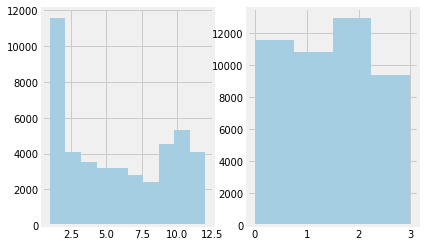

In [ ]:
##добавим группировку по периодам признака recency
d1= pd.qcut(X_train['recency'], 4, labels=False)
plt.subplot(1,2,1)
plt.hist(X_train['recency'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.subplot(1,2,2)
plt.hist(d1,bins=4)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [ ]:
##Добавим признак 'recency_bins'
X_train['recency_bins'] = d1

History

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


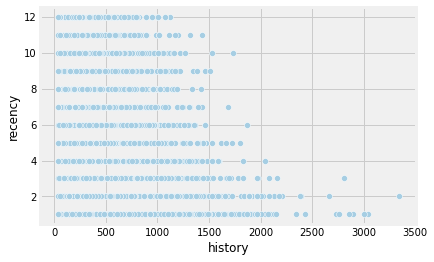

In [ ]:
## посмотрим выбросы history и recency
sns.scatterplot(X_train['history'], X_train['recency'] )
##Все значения положительные


In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')

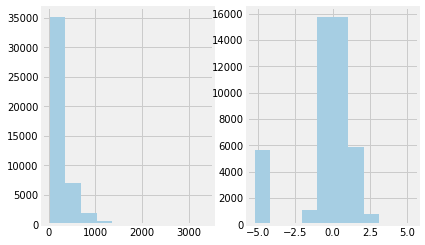

In [ ]:
dq =qt.fit_transform(X_train['history'].values.reshape(-1,1))
plt.subplot(1,2,1)
plt.hist(X_train['history'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.subplot(1,2,2)
plt.hist(dq)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


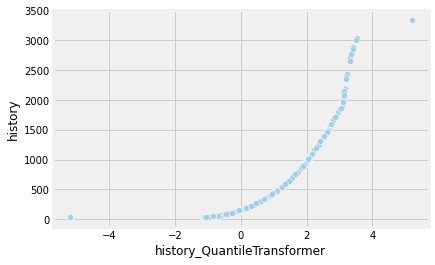

In [ ]:
X_train['history_QuantileTransformer'] = dq
sns.scatterplot(X_train['history_QuantileTransformer'], X_train['history'] )

In [ ]:
## Видим, что есть достаточно большая группа - почти 15% от тренировочной выборки, которая на графике QuantileTransformer и history показывает самое боьшое отрицательное значение std. Учтем это при работе с признаком history
X_train.loc[X_train['history_QuantileTransformer'] < -3]['history'].describe()

count    5.614000e+03
mean     2.999000e+01
std      2.806894e-13
min      2.999000e+01
25%      2.999000e+01
50%      2.999000e+01
75%      2.999000e+01
max      2.999000e+01
Name: history, dtype: float64

In [ ]:
## Разобьем датасет на группы в зависимости от значения признакак history
X_train['30_days'] = (X_train['history'] <=30).astype(int)
X_train['90_days'] = (X_train['history'] <=90).astype(int)
X_train['180_days'] = (X_train['history'] <=180).astype(int)
X_train['270_days'] = (X_train['history'] <=270).astype(int)
X_train['365_days'] = (X_train['history'] <=365).astype(int)
X_train['later_365 days'] = (X_train['history'] >365).astype(int)

In [ ]:
X_train.head(3)

recency  history  used_discount  ...  270_days 365_days  later_365 days
26161        1   571.68              0  ...         0        0               1
10495       12    61.40              1  ...         1        1               0
50047        3   465.79              0  ...         0        0               1

[3 rows x 17 columns]

In [ ]:
## внесем все изменения в тестовую выборку
# добавим признак для этих групп - возведем сумму значений по этим признакам в квадрат
X_test['bogo_discount'] = (X_test['used_bogo'] + X_test['used_discount'])**2
# добавим признак для этих двух признаков - возведем сумму значений по этим признакам в квадрат
X_test['bogo_discount_referral'] = (X_test['used_bogo'] + X_test['used_discount'] + X_test['is_referral'])**2
##добавим группировку по периодам признака recency
d1= pd.qcut(X_test['recency'], 4, labels=False)
X_test['recency_bins'] = d1
dq1 =qt.fit_transform(X_test['history'].values.reshape(-1,1))
X_test['history_QuantileTransformer'] = dq1

## Разобьем датасет на группы в зависимости от значения признакак history
X_test['30_days'] = (X_test['history'] <=30).astype(int)
X_test['90_days'] = (X_test['history'] <=90).astype(int)
X_test['180_days'] = (X_test['history'] <=180).astype(int)
X_test['270_days'] = (X_test['history'] <=270).astype(int)
X_test['365_days'] = (X_test['history'] <=365).astype(int)
X_test['later_365 days'] = (X_test['history'] >365).astype(int)
X_test.head(3)

recency  history  used_discount  ...  270_days 365_days  later_365 days
11277        3   466.66              0  ...         0        0               1
55819        8    44.25              0  ...         1        1               0
43223       10   370.84              0  ...         0        0               1

[3 rows x 17 columns]

In [ ]:
X_train.columns.tolist()

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'zip_code',
 'is_referral',
 'channel',
 'bogo_discount',
 'bogo_discount_referral',
 'recency_bins',
 'history_QuantileTransformer',
 '30_days',
 '90_days',
 '180_days',
 '270_days',
 '365_days',
 'later_365 days']

провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner)


In [ ]:
!pip install scikit-uplift==0.2.0

In [ ]:
!pip install catboost

In [ ]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

In [ ]:
from catboost import CatBoostClassifier

1.1 Одна модель с признаком коммуникации


In [ ]:
cat_features = ['zip_code', 'channel']
models_results = {'approach' : [],
                  'uplift@10%' : [],
                  'uplift@20%' : [],
                  'uplift@30%' : []
                  }

In [ ]:
features = [##'recency',
 ##'history',
 ##'used_discount',
 ##'used_bogo',
 'zip_code',
 'is_referral',
 'channel',
 'bogo_discount',
 'bogo_discount_referral',
 'recency_bins',
 'history_QuantileTransformer',
 '30_days',
 ##'90_days',
 '180_days',
 '270_days',
 '365_days',
 ##'later_365 days'
]

X_train_features = X_train[features]
X_test_features = X_test[features]

uplift@10%: 0.0889
uplift@20%: 0.0823
uplift@20%: 0.0673


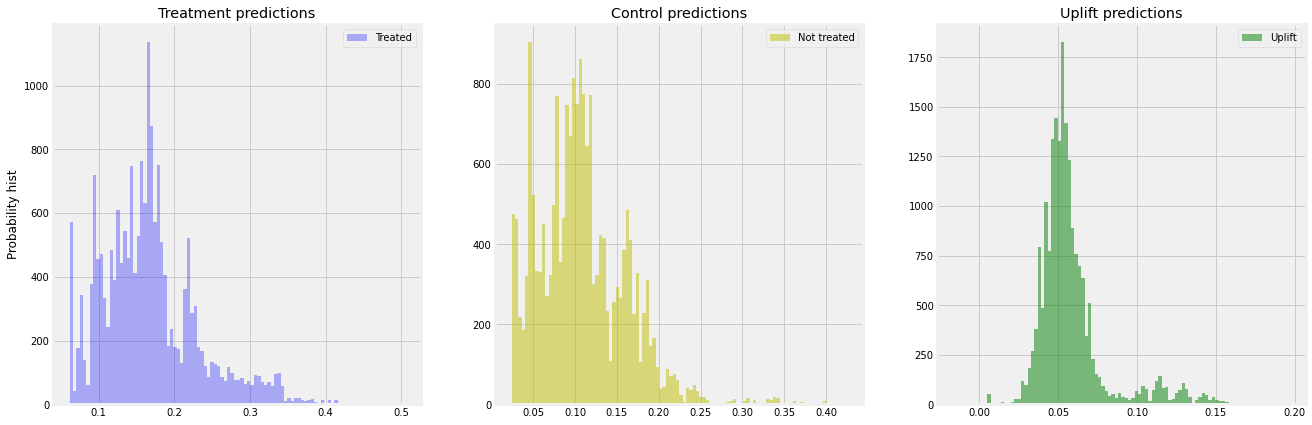

In [ ]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train_features, y_train, treat_train, estimator_fit_params= {'cat_features': cat_features})

uplift_sm = sm.predict(X_test_features)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score_10:.4f}')

sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score_20:.4f}')

sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@20%: {sm_score_30:.4f}')


models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [ ]:
models_results

{'approach': ['SoloModel'],
 'uplift@10%': [0.08891495283900347],
 'uplift@20%': [0.08229199950841834],
 'uplift@30%': [0.0673418767183159]}

Посмотрим на топ-признаки

In [ ]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

feature_name  feature_score
0                     treatment      20.633116
1        bogo_discount_referral      17.743364
2                  recency_bins      12.824958
3                      zip_code      12.125170
4                 bogo_discount      11.361492
5                   is_referral       8.843444
6                       channel       8.178911
7   history_QuantileTransformer       6.239673
8                      180_days       1.129253
9                      365_days       0.677785
10                      30_days       0.242835
11                     270_days       0.000000

модель с трансформацией таргета (трансформация классов п. 2. 1)

In [ ]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train_features, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test_features)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


In [ ]:
models_results

{'approach': ['SoloModel', 'ClassTransformation'],
 'uplift@10%': [0.08891495283900347, 0.07450478494782292],
 'uplift@20%': [0.08229199950841834, 0.07091280570234729],
 'uplift@30%': [0.0673418767183159, 0.06832096359729595]}

вариант с двумя независимыми моделями

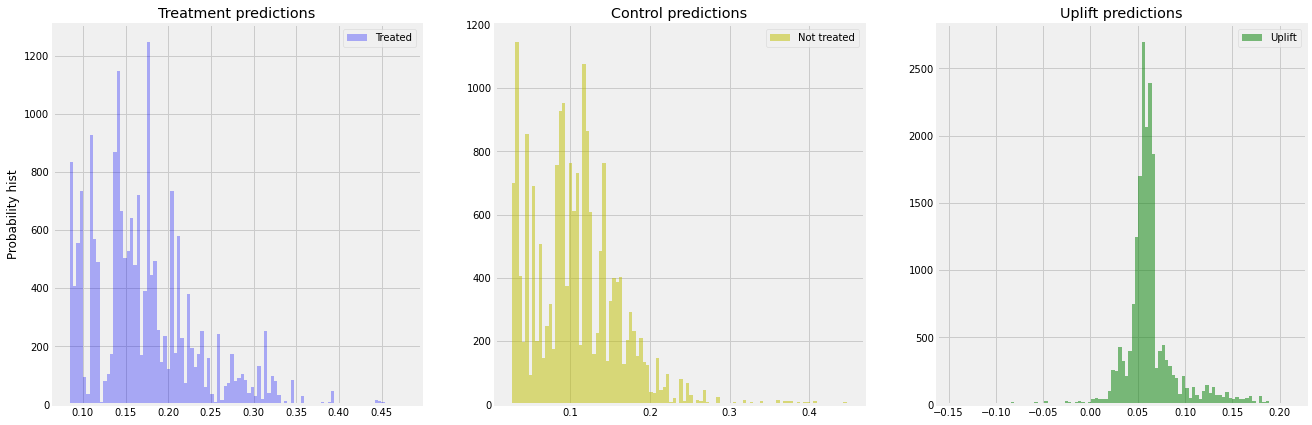

In [ ]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train_features, y_train, treat_train, estimator_trmnt_fit_params = {'cat_features': cat_features},
    estimator_ctrl_fit_params = {'cat_features': cat_features})

uplift_tm = tm.predict(X_test_features)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [ ]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@10%': [0.08891495283900347, 0.07450478494782292, 0.07450478494782292],
 'uplift@20%': [0.08229199950841834, 0.07091280570234729, 0.07091280570234729],
 'uplift@30%': [0.0673418767183159, 0.06832096359729595, 0.06832096359729595]}

In [ ]:
table_1 =pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)
table_1

approach  uplift@10%  uplift@20%  uplift@30%
0            SoloModel    0.088915    0.082292    0.067342
1  ClassTransformation    0.074505    0.070913    0.068321
2            TwoModels    0.074505    0.070913    0.068321

построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [ ]:
X_train_tree = X_train_features

In [ ]:
X_train_tree = pd.concat([X_train.drop(cat_features, 1), pd.get_dummies(X_train[cat_features], prefix = cat_features)], 1)
features = [col for col in X_train_tree]
features

['bogo_discount',
 'bogo_discount_referral',
 'recency_bins',
 'history_QuantileTransformer',
 '30_days',
 '90_days',
 '180_days',
 '270_days',
 'zip_code_Rural',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Multichannel',
 'channel_Phone',
 'channel_Web']

In [ ]:
pip install causalml

In [ ]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

CPU times: user 9.13 s, sys: 84.2 ms, total: 9.21 s
Wall time: 9.23 s


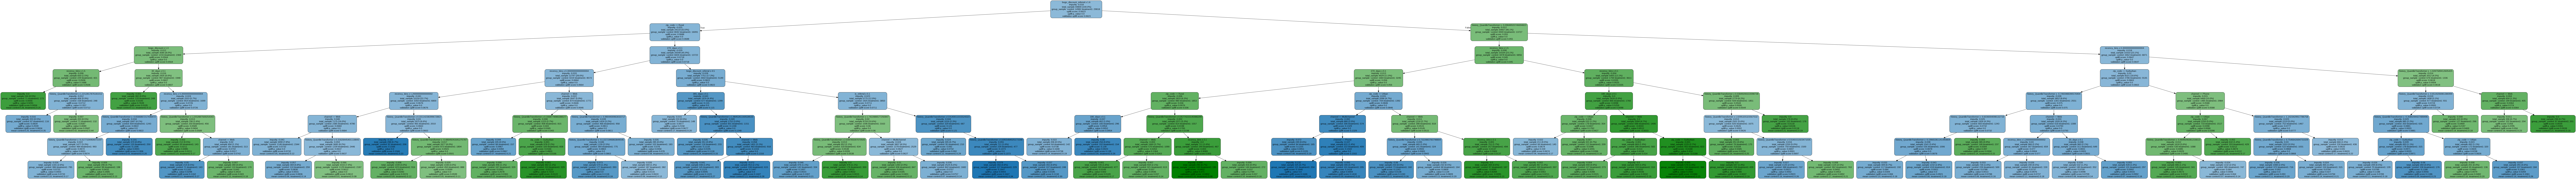

In [ ]:
display(Image(graph.create_png()))